# Intermediate machine learning Kaggle

## Intro

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_full = pd.read_csv('data/intermediate_train.csv', index_col='Id')
X_test_full = pd.read_csv('data/intermediate_test.csv', index_col='Id')

# Obtain target and predictors
y = X_full.SalePrice
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_test_full[features].copy()

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [9]:
X_train.head()

,LotArea,YearBuilt,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd
Id,,,,,,,
619,11694,2007,1828,0,2,3,9
871,6600,1962,894,0,1,2,5
93,13360,1921,964,0,1,2,5
818,13265,2002,1689,0,2,3,7
303,13704,2001,1541,0,2,3,6


In [7]:
from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [10]:
from sklearn.metrics import mean_absolute_error

# Function for comparing different models
def score_model(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return mean_absolute_error(y_v, preds)

for i in range(0, len(models)):
    mae = score_model(models[i])
    print("Model %d MAE: %d" % (i+1, mae))

Model 1 MAE: 24015
Model 2 MAE: 23740
Model 3 MAE: 23528
Model 4 MAE: 23996
Model 5 MAE: 23706


## Missing values

### Example

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('data/melb_data.csv')

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Dropping columns with missing values

In [14]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


Using simple imputer on columns with missing values

In [15]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
178166.46269899711


Using extension to imputation on columns with missing values

In [17]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


In [20]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


### Exercise

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_full = pd.read_csv('data/intermediate_train.csv', index_col='Id')
X_test_full = pd.read_csv('data/intermediate_test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X_full.SalePrice
X_full.drop(['SalePrice'], axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [23]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
619,20,90.0,11694,9,5,2007,2007,452.0,48,0,...,774,0,108,0,0,260,0,0,7,2007
871,20,60.0,6600,5,5,1962,1962,0.0,0,0,...,308,0,0,0,0,0,0,0,8,2009
93,30,80.0,13360,5,7,1921,2006,0.0,713,0,...,432,0,0,44,0,0,0,0,8,2009
818,20,NaN,13265,8,5,2002,2002,148.0,1218,0,...,857,150,59,0,0,0,0,0,7,2008
303,20,118.0,13704,7,5,2001,2002,150.0,0,0,...,843,468,81,0,0,0,0,0,1,2006


In [24]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(1168, 36)
LotFrontage    212
MasVnrArea       6
GarageYrBlt     58
dtype: int64


In [66]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1168.000000,956.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1162.000000,1168.000000,1168.000000,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.605308,69.614017,10589.672945,6.086473,5.572774,1970.890411,1984.692637,103.481067,439.890411,45.571918,...,473.632705,94.498288,48.044521,23.022260,3.218322,14.528253,2.118151,50.936644,6.301370,2007.819349
std,42.172322,22.946069,10704.180793,1.367472,1.116908,30.407486,20.684612,182.676225,435.106803,156.229962,...,209.442320,127.312017,68.619199,63.153093,27.916593,54.009608,36.482294,550.380636,2.725977,1.335971
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7589.500000,5.000000,5.000000,1953.750000,1966.000000,0.000000,0.000000,0.000000,...,336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9512.500000,6.000000,5.000000,1972.000000,1993.000000,0.000000,379.500000,0.000000,...,477.500000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,167.750000,716.000000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,1120.000000,...,1390.000000,736.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [67]:
X_train.describe()['LotFrontage']

count    956.000000
mean      69.614017
std       22.946069
min       21.000000
25%       59.000000
50%       69.000000
75%       80.000000
max      313.000000
Name: LotFrontage, dtype: float64

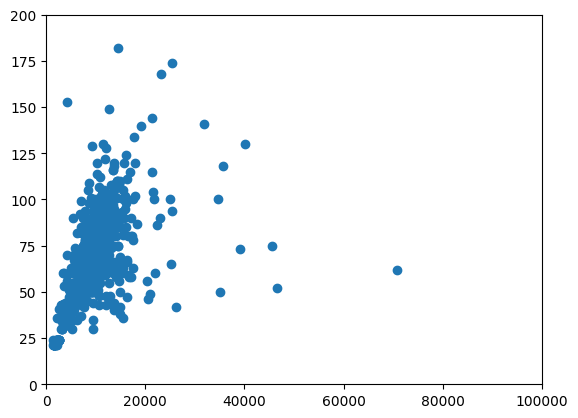

In [77]:
import matplotlib.pyplot as plt

plt.scatter(X_train.LotArea, X_train.LotFrontage)

plt.xlim(0, 100000)
plt.ylim(0, 200)
 
# To show the plot
plt.show()

In [83]:
len(list(X_train.LotArea))

1168

In [84]:
len(list(X_train.LotFrontage))

1168

In [86]:
list(X_train.LotFrontage.isna())

[False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fa

In [79]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.array(X_train.LotArea), np.array(X_train.LotFrontage))

reg.score(X, y)

ValueError: Expected 2D array, got 1D array instead:
array=[11694  6600 13360 ...  8930  3196 16770].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
X_train.loc[X_train['GarageYrBlt'].isna()][['YearBuilt', 'GarageYrBlt']]

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

Dropping columns with missing values

In [29]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

In [30]:
print("MAE (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE (Drop columns with missing values):
17837.82570776256


Using simple imputer on columns with missing values

In [34]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

In [35]:
print("MAE (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE (Imputation):
18062.894611872147


Other methods replacing GarageYrBlt

In [59]:
copy_X_train = X_train

copy_X_valid = X_valid

copy_X_train['GarageYrBlt'] = copy_X_train['GarageYrBlt'].fillna(copy_X_train['YearBuilt'])

copy_X_valid['GarageYrBlt'] = copy_X_valid['GarageYrBlt'].fillna(copy_X_valid['YearBuilt'])


In [60]:
copy_imputed_X_train = pd.DataFrame(my_imputer.fit_transform(copy_X_train))
copy_imputed_X_valid = pd.DataFrame(my_imputer.transform(copy_X_valid))

# Fill in the lines below: imputation removed column names; put them back
copy_imputed_X_train.columns = copy_X_train.columns
copy_imputed_X_valid.columns = copy_X_valid.columns

In [61]:
print("MAE (Imputation):")
print(score_dataset(copy_imputed_X_train, copy_imputed_X_valid, y_train, y_valid))

MAE (Imputation):
17996.141506849315
